## Prerequisites

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, AutoConfig
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import nltk
import numpy as np
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import json
from collections import Counter
from wordcloud import WordCloud

#my custom modules
from fnc_dataset import FNCDataset
from model_performance_tracker import ModelPerformanceTracker



In [2]:
#can see more of each dataframe before it truncates
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 1000)



In [3]:
nltk.download("punkt_tab")
nltk.download("stopwords")

#load the training data
trainData = FNCDataset.from_csv(labelledStancesPath="fnc-1/train_stances.csv", articlesPath="fnc-1/train_bodies.csv")
print(f"total stance count: {len(trainData.stances)}")
print(f"total article count: {len(trainData.articles)}")

stopWords = set(nltk.corpus.stopwords.words("english"))



[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kenny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kenny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


total stance count: 49972
total article count: 1683


## Perform N-Gram Analysis

In [19]:
def ngram_tokenizer(text):
    tokens = nltk.tokenize.word_tokenize(text.lower())
    return [token for token in tokens if token.isalnum() and token not in stopWords]  #remove stopwords/punctuation


def get_ngram_count(textDataFrame):
    #extract all ngrams from the text, keep top 50 most frequent
    vectorizer = CountVectorizer(tokenizer=ngram_tokenizer, ngram_range=(1, 5), max_features=50)
    nGramMatrix = vectorizer.fit_transform(textDataFrame)
    nGramFeatures = pd.DataFrame(nGramMatrix.toarray(), columns=vectorizer.get_feature_names_out())

    #count ngrams and sort in descending frequency
    nGramCounts = nGramFeatures.sum(axis=0).sort_values(ascending=False)
    nGramCounts = nGramCounts.reset_index()
    nGramCounts.columns = ["nGram", "count"]
    return nGramCounts


#get list of ngrams for related headlines and their article bodies
relatedHeadlineNGramCounts = get_ngram_count(trainData.relatedStances["Headline"])
relatedBodyNGramCounts = get_ngram_count(trainData.relatedBodies["articleBody"])

#get list of ngrams for unrelated headlines and their article bodies
unrelatedHeadlineNGramCounts = get_ngram_count(trainData.unrelatedStances["Headline"])
unrelatedBodyNGramCounts = get_ngram_count(trainData.unrelatedBodies["articleBody"])

#normalise ngram counts based on the number of related and unrelated stances
normalisationFactor = len(trainData.relatedStances) / len(trainData.unrelatedStances)
unrelatedHeadlineNGramCounts["count"] = (unrelatedHeadlineNGramCounts["count"] * normalisationFactor).round().astype(int)
unrelatedBodyNGramCounts["count"] = (unrelatedBodyNGramCounts["count"] * normalisationFactor).round().astype(int)

#show ngram counts for related headlines and bodies
relatedNGramCounts = pd.concat([relatedHeadlineNGramCounts, relatedBodyNGramCounts], axis=1)
newLevelColumnNames = (["related headlines"] * 2) + (["related article bodies"] * 2)
relatedNGramCounts.columns = pd.MultiIndex.from_tuples(zip(newLevelColumnNames, relatedNGramCounts.columns))
print(relatedNGramCounts)

#show ngram counts for unrelated headlines and bodies
print("================================================================================================")
unrelatedNGramCounts = pd.concat([unrelatedHeadlineNGramCounts, unrelatedBodyNGramCounts], axis=1)
newLevelColumnNames = (["unrelated headlines"] * 2) + (["unrelated article bodies"] * 2)
unrelatedNGramCounts.columns = pd.MultiIndex.from_tuples(zip(newLevelColumnNames, unrelatedNGramCounts.columns))
print(unrelatedNGramCounts)

#additional information
print("================================================================================================")
print(f"related headlines: {len(trainData.relatedStances)}")
print(f"unrelated headlines: {len(trainData.unrelatedStances)}")



c:\Users\kenny\Desktop\Durham\Year 4\Natural Language Processing\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\kenny\Desktop\Durham\Year 4\Natural Language Processing\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\kenny\Desktop\Durham\Year 4\Natural Language Processing\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\kenny\Desktop\Durham\Year 4\Natural Language Processing\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


         related headlines       related article bodies       
                     nGram count                  nGram  count
0                     isis  2194                   said  39672
1                    foley  1043                  video  13812
2                    james   979                    one  11550
3                    video   926                   isis  11507
4               journalist   908                  state  11362
5                  michael   842                  group  11172
6                     says   790                   told   9974
7                  islamic   774                  would   9965
8                    state   753                   also   9822
9                     boko   747                  foley   9446
10                   haram   747                islamic   9436
11              boko haram   747                 people   9296
12                american   723                    man   8693
13                   brown   691                    new

## Prerequisites

#### Define logic for the latent Dirichlet allocation (LDA)

In [4]:
lemmatizer = nltk.stem.WordNetLemmatizer()


def lda_tokenizer(text):
    tokens = nltk.tokenize.word_tokenize(text.lower())
    return [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stopWords]  #apply lemmatization and remove stopwords/punctuation  


def get_lda_topics(textDataFrame, numberOfTopics=60, alpha=0.02): #determined by rpc method shown in a later cell
    vectorizer = CountVectorizer(tokenizer=lda_tokenizer)
    wordMatrix = vectorizer.fit_transform(textDataFrame)
    lda = LatentDirichletAllocation(
        n_components=numberOfTopics,
        doc_topic_prior=alpha,
        learning_method="online",
        random_state=0 #reproducibility
    )

    lda.fit(wordMatrix)
    
    #pack each topic into a numpy array
    topicList = []
    for weights in lda.components_:
        dtype = [("token", "U50"), ("tokenWeight", "f4")]
        topic = np.array(list(zip(vectorizer.get_feature_names_out(), weights)), dtype=dtype)
        topic = topic[np.argsort(-topic["tokenWeight"])] #sort in descending order by tokenWeight
        topicList.append(topic)

    #average the topic weights across all related article bodies, room for other methods here
    topicDistributions = lda.transform(wordMatrix)   
    meanTopicDistribution = np.mean(topicDistributions, axis=0)                     

    #pair all topics with their distributions, pack into a document-wide topic array
    dtype = [("topic", object), ("topicWeight", "f4")]
    topicArray = np.array(list(zip(topicList, meanTopicDistribution)), dtype=dtype)
    topicArray = topicArray[np.argsort(-topicArray["topicWeight"])] #sort in descending order by topicWeight

    perplexity = lda.perplexity(wordMatrix)
    return topicArray, perplexity



## Perform Topic Analysis

In [18]:
def array_to_dataframe_topics(topicArray):
    topicDataFrameList = []
    #select top 10 topics across all article bodies
    for i, topic in enumerate(topicArray[:10]):
        topicWeight = topic["topicWeight"]

        #select top 10 tokens in each topic, pack data into a dataframe and format column names
        topicDataframe = pd.DataFrame(topic["topic"][:10])
        topicDataframe.columns = pd.MultiIndex.from_tuples([
            (f"topic {i + 1} (weight {topicWeight:.2f})", "token"),
            (f"topic {i + 1} (weight {topicWeight:.2f})", "token weight")
        ])
        topicDataFrameList.append(topicDataframe)
        
    #combine all topics into a single dataframe
    topicsDataFrame = pd.concat(topicDataFrameList, axis=1)
    return topicsDataFrame


relatedTopicArray, relatedPerplexity = get_lda_topics(trainData.relatedBodies["articleBody"])
relatedTopicsDataFrame = array_to_dataframe_topics(relatedTopicArray)
print(relatedTopicsDataFrame)
print(f"perplexity of related article bodies: {relatedPerplexity}")

unrelatedTopicArray, unrelatedPerplexity = get_lda_topics(trainData.unrelatedBodies["articleBody"])
unrelatedTopicsDataFrame = array_to_dataframe_topics(unrelatedTopicArray)
print(unrelatedTopicsDataFrame)
print(f"perplexity of unrelated article bodies: {unrelatedPerplexity}")



c:\Users\kenny\Desktop\Durham\Year 4\Natural Language Processing\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


  topic 1 (weight 0.07)              topic 2 (weight 0.05)              topic 3 (weight 0.04)              topic 4 (weight 0.04)              topic 5 (weight 0.04)              topic 6 (weight 0.04)              topic 7 (weight 0.04)              topic 8 (weight 0.03)              topic 9 (weight 0.03)              topic 10 (weight 0.03)             
                  token token weight                 token token weight                 token token weight                 token token weight                 token token weight                 token token weight                 token token weight                 token token weight                 token token weight                  token token weight
0                 foley  7299.572266                 brown  5281.822754                border  4236.346680                 haram  3944.670654                 story  1889.667847                 ebola  3463.044922                emwazi  2791.555908                   job  2256.273926             

c:\Users\kenny\Desktop\Durham\Year 4\Natural Language Processing\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


  topic 1 (weight 0.03)              topic 2 (weight 0.03)              topic 3 (weight 0.03)               topic 4 (weight 0.03)              topic 5 (weight 0.03)              topic 6 (weight 0.03)              topic 7 (weight 0.03)              topic 8 (weight 0.02)              topic 9 (weight 0.02)              topic 10 (weight 0.02)              
                  token token weight                 token token weight                 token  token weight                 token token weight                 token token weight                 token token weight                 token token weight                 token token weight                 token token weight                  token  token weight
0                 foley  8341.523438                 brown  9174.969727                 apple  16628.904297                 story  8523.299805                spider  3383.841797                 would  3055.536133               service  3763.784180            parliament  3848.836914        

## Find Optimal Topic Number

Perform "rate of perplexity change" based optimisation for the number of topics to use in LDA

__WARNING: The cell below has a very long runtime__

In [6]:
def calculate_rpc_values(perplexityValues, candidateTopicNumbers):
    rpcValues = []
    for i in range(1, len(perplexityValues)):
        rpcValues.append(abs((perplexityValues[i] - perplexityValues[i - 1]) / (candidateTopicNumbers[i] - candidateTopicNumbers[i - 1])))
    return rpcValues


candidateTopicNumbers = range(10, 140, 10)
perplexityValues = []

for candidateTopicNumber in candidateTopicNumbers:
    _, perplexity = get_lda_topics(trainData.relatedBodies["articleBody"], numberOfTopics=candidateTopicNumber)
    perplexityValues.append(perplexity)

rpcValues = calculate_rpc_values(perplexityValues, candidateTopicNumbers)

#smallest i for which rpc increases is the index of the optimal topic number
optimalIndex = None
for i in range(0, len(rpcValues) - 1):
    if rpcValues[i] < rpcValues[i + 1]:
        optimalIndex = i + 1
        break

#default to topic number with the smallest perplexity if no rpc increase is found
if optimalIndex is None:
    optimalIndex = perplexityValues.index(min(perplexityValues))

optimalTopicNumber = candidateTopicNumbers[optimalIndex]
print(f"optimal number of topics: {optimalTopicNumber}")
    
    

c:\Users\kenny\Desktop\Durham\Year 4\Natural Language Processing\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[np.float64(1619.9123229429947), np.float64(1265.764137320844), np.float64(1123.9719960641987), np.float64(1061.7636244714522), np.float64(1077.071412280876), np.float64(1071.9915713927103), np.float64(1062.8789225164087), np.float64(1152.808074482595), np.float64(1090.925890402325), np.float64(1161.5216406872278), np.float64(1193.2435925559582), np.float64(1179.385666902649), np.float64(1219.518480317095)]
[np.float64(35.414818562215075), np.float64(14.17921412566452), np.float64(6.220837159274652), np.float64(1.5307787809423872), np.float64(0.5079840888165791), np.float64(0.9112648876301591), np.float64(8.992915196618629), np.float64(6.188218408027001), np.float64(7.059575028490281), np.float64(3.172195186873046), np.float64(1.3857925653309167), np.float64(4.013281341444599)]
60


## Topic Word Cloud

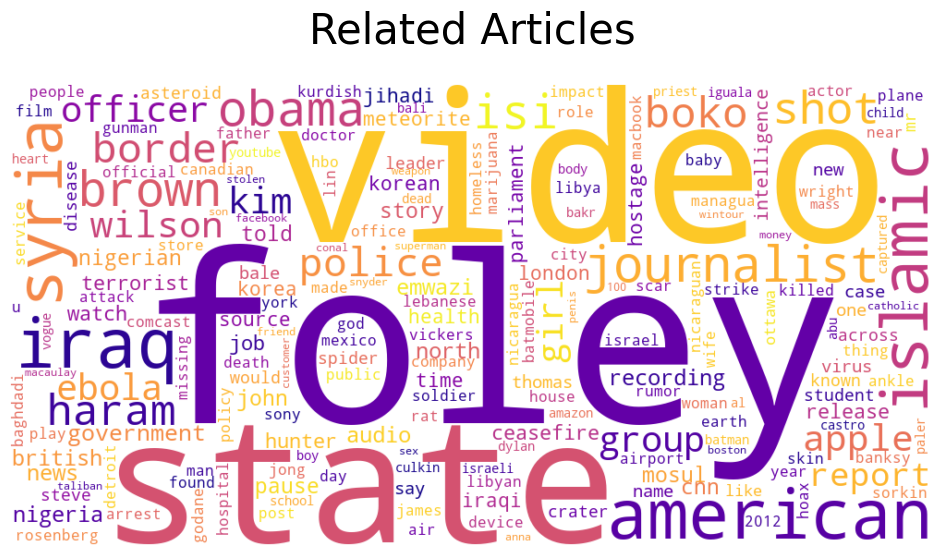

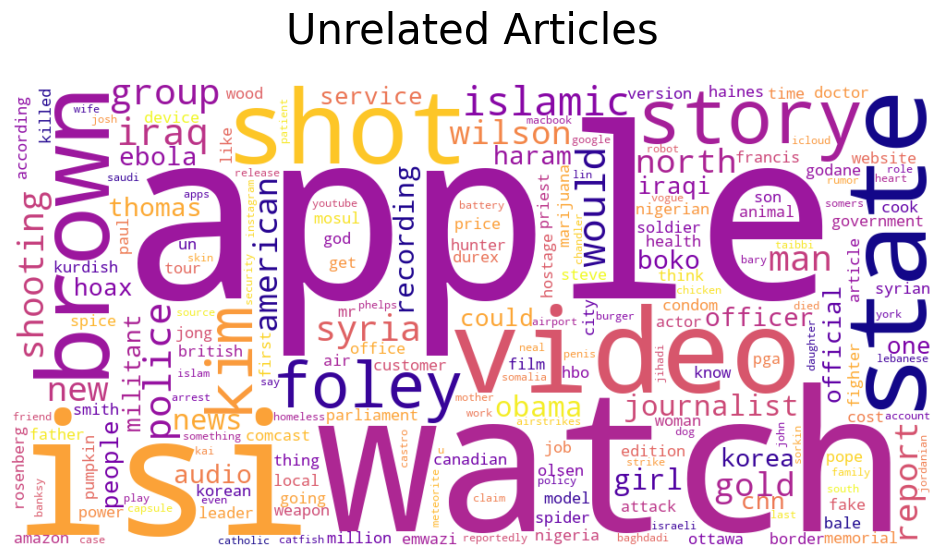

In [ ]:
def get_topic_token_weights(topicArray, topNWords, topNTopics, excludedWords=[]):
    cumulativeTokenTopicWeights = {}

    #select top n topics
    topTopics = topicArray[:topNTopics]
    for topic in topTopics:
        tokenList = topic[0]
        topicWeight = topic[1]
        
        #select top x tokens in each topic
        topTokens = tokenList[:topNWords]
        for token in topTokens:
            tokenWord = token[0]
            tokenWeight = token[1]
            totalWeight = topicWeight * tokenWeight
            
            if tokenWord not in excludedWords:
                cumulativeTokenTopicWeights[tokenWord] = cumulativeTokenTopicWeights.get(tokenWord, 0) + totalWeight
    
    return cumulativeTokenTopicWeights


def create_word_cloud(tokenTopicWeights, name="Topic"):
    wordCloud = WordCloud(
        width=1000, height=500,
        background_color="white",
        colormap="plasma",
        max_words=200
    ).generate_from_frequencies(tokenTopicWeights)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{name} Articles", fontsize=30, pad=30)
    plt.savefig(f"{name}_word_cloud.png", dpi=300, bbox_inches="tight")
    plt.show()


#skews both sets by being the most common word by far, so i remove it for analysis
exludedWords = ["said"]

relatedTopicTokenWeights = get_topic_token_weights(relatedTopicArray, 10, 50, excludedWords=exludedWords)
create_word_cloud(relatedTopicTokenWeights, name="Related")

unrelatedTopicTokenWeights = get_topic_token_weights(unrelatedTopicArray, 10, 50, excludedWords=exludedWords)   
create_word_cloud(unrelatedTopicTokenWeights, name="Unrelated") 



## Prerequisites

#### Data Preprocessing Logic

Logic for setting up the training and evaluation data loaders.

Function for showing class distribution in both the training and evaluation data splits. 

These cells also needs to be run before loading a model from disk for evaluation.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
batchSize = 8
maxSequenceLength = 256
#overlap accounts for the portion of the article body that is lost when we append the headline and truncate
strideRatio = 0.75 


def classification_tokenizer_with_chunking(examples):
    #use a modified sliding window approach to create multiple examples from each article body
    #only do this for the underrepresented classes: 0, 1, 2 (agree, disagree, discuss)

    #each tokenisation is done individually, so the data is collected in lists
    inputIdList = []
    attentionMaskList = []
    labelList = []

    headlines = examples["headline"]
    bodies    = examples["body"]
    labels    = examples["label"]

    for headline, body, label in zip(headlines, bodies, labels):
        #agree, disagree and discuss are underrepresented classes
        if label in [0, 1, 2]:
            #underrepresented classes are filled out using sliding window on the article bodies

            #tokenise the body
            bodyTokens = tokenizer.tokenize(body)

            #use strideRatio to determine the stride of the sliding window (in tokens)
            windowStride = int(maxSequenceLength * strideRatio)
            if windowStride < 1:
                windowStride = 1

            startToken = 0
            while startToken < len(bodyTokens):
                chunk_tokens = bodyTokens[startToken : startToken + maxSequenceLength]
                chunk_text = tokenizer.convert_tokens_to_string(chunk_tokens)

                #now tokenise the (headline, chunk) pair and rely on truncation to enforce maxSequenceLength
                tokenized = tokenizer(headline, chunk_text, truncation=True, padding="max_length", max_length=maxSequenceLength)
                inputIdList.append(tokenized["input_ids"])
                attentionMaskList.append(tokenized["attention_mask"])
                labelList.append(label)

                startToken += windowStride

        else:
            #the example is in the unrelated class, dosent need extending with chunking
            tokenized = tokenizer(headline, body, truncation=True, padding="max_length", max_length=maxSequenceLength)
            inputIdList.append(tokenized["input_ids"])
            attentionMaskList.append(tokenized["attention_mask"])
            labelList.append(label)

    #this format is expected by the model
    tokenizeOutputs = {
        "input_ids": inputIdList,
        "attention_mask": attentionMaskList,
        "label": labelList,
    }
    return tokenizeOutputs


#basic tokeniser that truncates the input to maxSequenceLength, truncates from the end of the text
def classification_tokenizer_truncation(examples):
    tokenizeOutputs = tokenizer(examples["headline"], examples["body"], truncation=True, padding="max_length", max_length=maxSequenceLength)
    #keep the label for evaluation
    tokenizeOutputs["label"] = examples["label"]
    return tokenizeOutputs



c:\Users\kenny\Desktop\Durham\Year 4\Natural Language Processing\.venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [6]:
#percentage and count of each stance class in the dataset, used for reporting and in considering class imbalance
def show_class_distribution(dataframe, stanceMapping):
    #count the occurrences of each class
    classCounts = Counter(dataframe["label"])
    totalSamples = sum(classCounts.values())

    #reverse mapping from integer class label to stance string
    reverseStanceMapping = {value: key for key, value in stanceMapping.items()}
    
    #print class distribution
    for label, count in sorted(classCounts.items()):
        percentage = (count / totalSamples) * 100
        print(f"Class {label} ({reverseStanceMapping[label]}): {count} samples ({percentage:.2f}%)")
    
    return classCounts


#load an instance of my custom FNCDataset class into a huggingface dataset, tokenise it, and pack it into a pytorch dataLoader
def fnc_dataset_to_dataloader(fncDataset, mapFunction):
    #drop Body ID column, rename columns, map stances to integers
    combinedDataframe = fncDataset.headlinesBodiesCombined
    combinedDataframe = combinedDataframe.drop(columns=["Body ID"])
    combinedDataframe = combinedDataframe.rename(columns={
        "Headline": "headline",
        "Stance": "label",
        "articleBody": "body"
    })
    stanceMapping = {"agree": 0, "disagree": 1, "discuss": 2, "unrelated": 3}
    combinedDataframe["label"] = combinedDataframe["label"].map(stanceMapping)

    #prints how many of each class are in the dataset
    print("Class distribution before tokenisation:")
    tokenizedClassCounts = show_class_distribution(combinedDataframe, stanceMapping)

    #pack into a huggingface dataset then tokenise 
    combinedDataframe.reset_index(drop=True, inplace=True)
    combinedDataset = Dataset.from_pandas(combinedDataframe, preserve_index=False)
    tokenizedDataset = combinedDataset.map(mapFunction, batched=True, remove_columns=["headline", "body", "label"])
    tokenizedDataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    
    #pack into a PyTorch DataLoader
    dataLoader = DataLoader(tokenizedDataset, batch_size=batchSize, shuffle=True, num_workers=4)
    return dataLoader, tokenizedClassCounts



## Load Training Data into DataLoaders

In [7]:
#split the FNCDataset into two seperate instances, one for training and one for evaluation
#load each into a DataLoader for training
trainingSplit, evaluationSplit = trainData.split(testSize=0.2, randomState=42)
print("Loading training dataset")
trainDataLoader, trainClassCounts = fnc_dataset_to_dataloader(trainingSplit, classification_tokenizer_with_chunking)
print("Loading evaluation dataset")
evalDataLoader, _ = fnc_dataset_to_dataloader(evaluationSplit, classification_tokenizer_truncation)



Loading training dataset
Class distribution before tokenisation:
Class 0 (agree): 2942 samples (7.36%)
Class 1 (disagree): 672 samples (1.68%)
Class 2 (discuss): 7127 samples (17.83%)
Class 3 (unrelated): 29236 samples (73.13%)


Map:   0%|          | 0/39977 [00:00<?, ? examples/s]

Loading evaluation dataset
Class distribution before tokenisation:
Class 0 (agree): 736 samples (7.36%)
Class 1 (disagree): 168 samples (1.68%)
Class 2 (discuss): 1782 samples (17.83%)
Class 3 (unrelated): 7309 samples (73.13%)


Map:   0%|          | 0/9995 [00:00<?, ? examples/s]

## Measure Length of Token Sequences

Mean sequence length: 473.70101256703754
Max sequence length: 5824


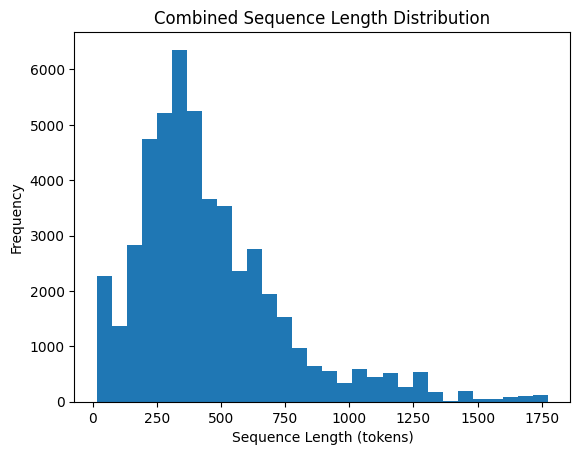

Mean headline length: 16.145761626510847
Max headline length: 84


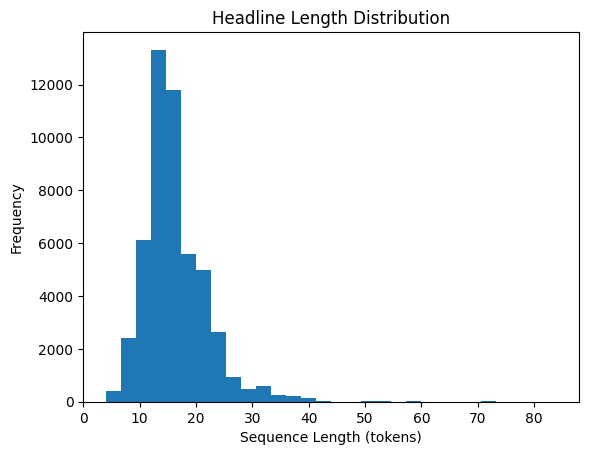

In [10]:
#measure the length of each token sequence, this is the headline and body concatenated
def get_full_sequence_lengths(dataframe):
    fullSequenceLengths = []
    for _, row in dataframe.iterrows():
        #tokenise without truncation or padding
        tokens = tokenizer(row["Headline"], row["articleBody"], truncation=False, padding=False)
        fullSequenceLengths.append(len(tokens["input_ids"]))
    return fullSequenceLengths


#measure the length of each token sequence, this is just for the headline
def get_headline_sequence_lengths(dataframe):
    headlineLengths = []
    for _, row in dataframe.iterrows():
        #tokenise without truncation or padding
        tokens = tokenizer(row["Headline"], truncation=False, padding=False)
        headlineLengths.append(len(tokens["input_ids"]))
    return headlineLengths


def plot_sequence_lengths(sequenceLengths, percentile, sequenceName="Sequence"):
    #filter out outliers, otherwise data is too concentrated to the left of the graph
    threshold = np.percentile(sequenceLengths, percentile)
    filteredLengths = [length for length in sequenceLengths if length <= threshold]

    #plot the sequence length distribution in a histogram
    plt.hist(filteredLengths, bins=30)
    plt.title(f"{sequenceName} Length Distribution")
    plt.xlabel("Sequence Length (tokens)")
    plt.ylabel("Frequency")
    #plt.savefig(f"{sequenceName.lower()}_length_distribution.png", dpi=300)
    plt.show()


#show the distribution of lengths for each (headline, body) pair in tokens
fullSequenceLengths = get_full_sequence_lengths(trainData.headlinesBodiesCombined)
print(f"Mean sequence length: {np.mean(fullSequenceLengths)}")
print(f"Max sequence length: {np.max(fullSequenceLengths)}")
plot_sequence_lengths(fullSequenceLengths, percentile=99, sequenceName="Combined Sequence")

#show the distribution of lengths for each headline in tokens
headlineLengths = get_headline_sequence_lengths(trainData.headlinesBodiesCombined)
print(f"Mean headline length: {np.mean(headlineLengths)}")
print(f"Max headline length: {np.max(headlineLengths)}")
plot_sequence_lengths(headlineLengths, percentile=100, sequenceName="Headline")

## Train Model

In [11]:
#Significant portions of code taken from the notebook for practical 3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed)

#augment counts to reflect that underrepresented classes are filled out with sliding window (roughly 3x more samples)
tokenizedTrainClassCounts = trainClassCounts.copy()
for k in [0, 1, 2]:
    tokenizedTrainClassCounts[k] *= 3

#use log weighting to account for class imbalance
totalSamples = sum(tokenizedTrainClassCounts.values())
classWeights = [np.log(1 + totalSamples / count) ** 1.2 for label, count in sorted(tokenizedTrainClassCounts.items())]
print(f"Class weights: {classWeights}")

#create a weighted loss function for training to account for class imbalance
classWeightsTensor = torch.tensor(classWeights, dtype=torch.float)
lossFn = torch.nn.CrossEntropyLoss(weight=classWeightsTensor.to(device))

#apply dropout to the model
config = AutoConfig.from_pretrained("microsoft/deberta-v3-base", num_labels=4)
config.hidden_dropout_prob = 0.2 
config.attention_probs_dropout_prob = 0.2

#cross entropy loss used by default
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", config=config)
model.to(device)

numEpochs = 5
totalTrainingSteps = len(trainDataLoader) * numEpochs
numWarmupSteps = totalTrainingSteps // 10
learningRate = 5e-5
optimiser = AdamW(model.parameters(), lr=learningRate, weight_decay=0.01)
lrScheduler = get_scheduler("linear", optimizer=optimiser, num_training_steps=totalTrainingSteps, num_warmup_steps=numWarmupSteps)
#lrScheduler = get_scheduler("cosine", optimizer=optimiser, num_training_steps=totalTrainingSteps, num_warmup_steps=numWarmupSteps)

#track model performance using a custom class i wrote
trainTracker = ModelPerformanceTracker(numLabels=4)
evalTracker = ModelPerformanceTracker(numLabels=4)

#main training and evaluation loop
for epoch in range(numEpochs):
    #reset performance trackers
    trainTracker.reset_epoch()
    evalTracker.reset_epoch()

    #training phase
    model.train()
    with torch.set_grad_enabled(True):
        for batch in tqdm(trainDataLoader, desc=f"Training  Epoch  {epoch + 1}"):
            #move batch to device
            inputIds = batch["input_ids"].to(device)
            attentionMask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimiser.zero_grad()

            #forward pass
            outputs = model(inputIds, attention_mask=attentionMask)
            logits = outputs.logits
            loss = lossFn(logits, labels) #use weighted loss in training

            #backward pass
            loss.backward()
            optimiser.step()
            lrScheduler.step()

            #update training metrics and pass to the performance tracker
            _, predicted = torch.max(logits, 1)
            trainTracker.update_batch(labels, predicted, loss, labels.size(0))

    #evaluation phase
    model.eval()
    with torch.no_grad():
        for batch in tqdm(evalDataLoader, desc=f"Evaluating Epoch {epoch + 1}"):
            #move batch to device
            inputIds = batch["input_ids"].to(device)
            attentionMask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            #forward pass
            outputs = model(inputIds, attention_mask=attentionMask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            #update evaluation metrics and pass to the performance tracker
            _, predicted = torch.max(logits, 1)
            evalTracker.update_batch(labels, predicted, loss, labels.size(0))

    #signal the end of the epoch to the performance trackers
    trainTracker.finish_epoch(epoch + 1)
    evalTracker.finish_epoch(epoch + 1)

    #print epoch summary
    trainMetricsDataframe = trainTracker.get_metrics_dataframe()
    evalMetricsDataframe = evalTracker.get_metrics_dataframe()

    print("training performance:")
    print(trainMetricsDataframe.iloc[epoch])
    print("evaluation performance:")
    print(evalMetricsDataframe.iloc[epoch])
    print("=================================")
    


Class weights: [np.float64(2.4009641601842735), np.float64(4.418878179289839), np.float64(1.439128423041037), np.float64(1.1605460932831424)]


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating Epoch 1: 100%|██████████| 1250/1250 [02:17<00:00,  9.07it/s]


training performance:
epoch              1.000000
overallAccuracy    0.814481
overallLoss        0.073007
classAccuracy_0    0.532485
classLoss_0        0.082973
classAccuracy_1    0.229053
classLoss_1        0.113168
classAccuracy_2    0.776149
classLoss_2        0.072229
classAccuracy_3    0.961110
classLoss_3        0.068088
Name: 0, dtype: float64
evaluation performance:
epoch              1.000000
overallAccuracy    0.937169
overallLoss        0.020573
classAccuracy_0    0.502717
classLoss_0        0.034705
classAccuracy_1    0.708333
classLoss_1        0.036808
classAccuracy_2    0.924242
classLoss_2        0.021012
classAccuracy_3    0.989328
classLoss_3        0.018669
Name: 0, dtype: float64


Evaluating Epoch 2: 100%|██████████| 1250/1250 [02:14<00:00,  9.27it/s]


training performance:
epoch              2.000000
overallAccuracy    0.909654
overallLoss        0.037647
classAccuracy_0    0.782641
classLoss_0        0.043389
classAccuracy_1    0.641547
classLoss_1        0.060270
classAccuracy_2    0.871943
classLoss_2        0.038147
classAccuracy_3    0.991415
classLoss_3        0.034133
Name: 1, dtype: float64
evaluation performance:
epoch              2.000000
overallAccuracy    0.976288
overallLoss        0.010906
classAccuracy_0    0.891304
classLoss_0        0.015899
classAccuracy_1    0.791667
classLoss_1        0.025684
classAccuracy_2    0.942200
classLoss_2        0.012527
classAccuracy_3    0.997400
classLoss_3        0.009669
Name: 1, dtype: float64


Evaluating Epoch 3: 100%|██████████| 1250/1250 [02:17<00:00,  9.09it/s]


training performance:
epoch              3.000000
overallAccuracy    0.958636
overallLoss        0.019086
classAccuracy_0    0.897369
classLoss_0        0.022718
classAccuracy_1    0.859197
classLoss_1        0.029303
classAccuracy_2    0.939511
classLoss_2        0.019145
classAccuracy_3    0.996716
classLoss_3        0.017340
Name: 2, dtype: float64
evaluation performance:
epoch              3.000000
overallAccuracy    0.983492
overallLoss        0.008796
classAccuracy_0    0.922554
classLoss_0        0.013114
classAccuracy_1    0.898810
classLoss_1        0.015368
classAccuracy_2    0.955107
classLoss_2        0.010426
classAccuracy_3    0.998495
classLoss_3        0.007812
Name: 2, dtype: float64


Evaluating Epoch 4: 100%|██████████| 1250/1250 [02:10<00:00,  9.58it/s]


training performance:
epoch              4.000000
overallAccuracy    0.983298
overallLoss        0.008336
classAccuracy_0    0.963212
classLoss_0        0.009597
classAccuracy_1    0.947447
classLoss_1        0.011689
classAccuracy_2    0.975178
classLoss_2        0.008530
classAccuracy_3    0.997400
classLoss_3        0.007612
Name: 3, dtype: float64
evaluation performance:
epoch              4.000000
overallAccuracy    0.990895
overallLoss        0.005516
classAccuracy_0    0.963315
classLoss_0        0.007609
classAccuracy_1    0.910714
classLoss_1        0.013710
classAccuracy_2    0.978676
classLoss_2        0.006560
classAccuracy_3    0.998495
classLoss_3        0.004862
Name: 3, dtype: float64


Evaluating Epoch 5: 100%|██████████| 1250/1250 [02:08<00:00,  9.74it/s]

training performance:
epoch              5.000000
overallAccuracy    0.993998
overallLoss        0.003148
classAccuracy_0    0.987031
classLoss_0        0.003678
classAccuracy_1    0.984135
classLoss_1        0.004244
classAccuracy_2    0.990834
classLoss_2        0.003100
classAccuracy_3    0.998974
classLoss_3        0.002963
Name: 4, dtype: float64
evaluation performance:
epoch              5.000000
overallAccuracy    0.992996
overallLoss        0.005566
classAccuracy_0    0.974185
classLoss_0        0.009768
classAccuracy_1    0.928571
classLoss_1        0.011801
classAccuracy_2    0.983165
classLoss_2        0.004957
classAccuracy_3    0.998769
classLoss_3        0.005148
Name: 4, dtype: float64


## Save Model to Disk
#### Will create a new folder in the modelDirectory each time it is run

In [12]:
#this is the top level directory which contains a subdirectory for each model
baseDirectory = "modelDirectory"
os.makedirs(baseDirectory, exist_ok=True)


#find the smallest positive integer i such that modelDirectory/modeli does not exist
def get_next_model_folder(baseDir):
    i = 1
    while os.path.exists(f"{baseDir}/model{i}"):
        i += 1
    return f"{baseDir}/model{i}"


#set up the directory to save the model weights and other info
saveDirectory = get_next_model_folder(baseDirectory)
os.makedirs(saveDirectory)

#save the model weights
modelPath = f"{saveDirectory}/model.pth"
torch.save(model.state_dict(), modelPath)
print(f"Model saved to {modelPath}")

#save the performance metrics
trainMetricsDataframe.to_csv(f"{saveDirectory}/train_metrics.csv")
evalMetricsDataframe.to_csv(f"{saveDirectory}/eval_metrics.csv")
print(f"Training metrics saved to {modelPath}")

#save model info
modelNotes = f"chunking used, weighted loss function, log weighting with 1.2 exponent, weightDecay=0.01, dropout=0.2"
modelInfo = {
    "model_name": "DeBERTa-v3-base",
    "epochs": numEpochs,
    "learning_rate": learningRate,
    "learning_rate_scheduler": "linear",
    "batch_size": batchSize,
    "max_sequence_length": maxSequenceLength,
    "notes": modelNotes
}

jsonPath = os.path.join(saveDirectory, "model_info.json")
with open(jsonPath, "w") as jsonFile:
    json.dump(modelInfo, jsonFile, indent=4)
print(f"Model info saved to {jsonPath}")



Model saved to modelDirectory/model6/model.pth
Training metrics saved to modelDirectory/model6/model.pth
Model info saved to modelDirectory/model6\model_info.json


## Plot Training and Evaluation Loss/Accuracy
#### Saves to the same directory as the model above

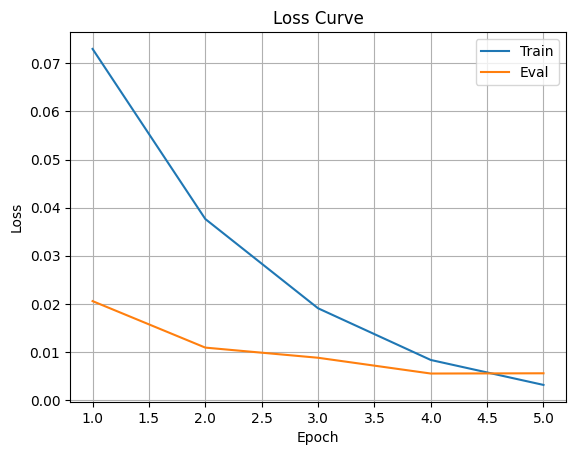

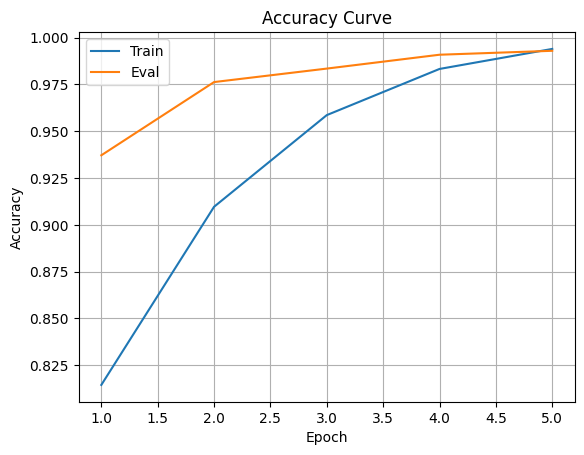

In [13]:
#uncomment this line below to plot without saving to storage
#saveDirectory = None


def loss_plot(epochs, trainLoss, evalLoss, savePath=None):
    #plots the training and evaluation loss over epochs.
    plt.plot(epochs, trainLoss, label="Train")
    plt.plot(epochs, evalLoss, label="Eval")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)
    if savePath:
        plotPath = os.path.join(savePath, "loss_plot.png")
        plt.savefig(plotPath, dpi=300)
    plt.show()

def accuracy_plot(epochs, trainAccuracy, evalAccuracy, savePath=None):
    #plots the training and evaluation accuracy over epochs.
    plt.plot(epochs, trainAccuracy, label="Train")
    plt.plot(epochs, evalAccuracy, label="Eval")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.grid(True)
    if savePath:
        plotPath = os.path.join(savePath, "accuracy_plot.png")
        plt.savefig(plotPath, dpi=300)
    plt.show()


#plot loss and accuracy and save to the same directory as the model weights
loss_plot(trainMetricsDataframe["epoch"], trainMetricsDataframe["overallLoss"], evalMetricsDataframe["overallLoss"], saveDirectory)
accuracy_plot(trainMetricsDataframe["epoch"], trainMetricsDataframe["overallAccuracy"], evalMetricsDataframe["overallAccuracy"], saveDirectory)



## Load Model from Disk

In [17]:
modelToLoadDir = "modelDirectory/model6"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed)

#load deberta model weights from local storage, set to evaluation mode
loadedModel = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=4)
loadedModel.to(device)
modelWeightsPath = f"{modelToLoadDir}/model.pth"
loadedModel.load_state_dict(torch.load(modelWeightsPath))
loadedModel.eval()

#read the competition data in for validation, this dataset is harder than the training set
validationData = FNCDataset.from_csv(labelledStancesPath="fnc-1/competition_test_stances.csv", articlesPath="fnc-1/competition_test_bodies.csv")
validationDataLoader, _ = fnc_dataset_to_dataloader(validationData, classification_tokenizer_truncation)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\kenny\AppData\Local\Temp\ipykernel_25116\2805604804.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they 

Class distribution before tokenisation:
Class 0 (agree): 1903 samples (7.49%)
Class 1 (disagree): 697 samples (2.74%)
Class 2 (discuss): 4464 samples (17.57%)
Class 3 (unrelated): 18349 samples (72.20%)


Map:   0%|          | 0/25413 [00:00<?, ? examples/s]

## Validate Loaded Model on Competition Set

In [18]:
validationTracker = ModelPerformanceTracker(numLabels=4)
validationTracker.reset_epoch()

with torch.no_grad():
    for batch in tqdm(validationDataLoader, desc=f"Validating on competition set"):
        #move batch to device
        inputIds = batch["input_ids"].to(device)
        attentionMask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        #forward pass
        outputs = loadedModel(inputIds, attention_mask=attentionMask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        #update evaluation metrics and pass to the performance tracker
        _, predicted = torch.max(logits, 1)
        validationTracker.update_batch(labels, predicted, loss, labels.size(0))

validationTracker.finish_epoch(1)
validationlMetricsDataframe = validationTracker.get_metrics_dataframe()

print("validation performance:")
print(validationlMetricsDataframe.iloc[0])

#save validation metrics to the same directory the model was loaded from
#validationlMetricsDataframe.to_csv(f"{modelToLoadDir}/validation_metrics.csv")


Validating on competition set: 100%|██████████| 3177/3177 [05:06<00:00, 10.36it/s]

validation performance:
epoch              1.000000
overallAccuracy    0.918349
overallLoss        0.064635
f1Score            0.732380
classAccuracy_0    0.668944
classLoss_0        0.091853
classAccuracy_1    0.451937
classLoss_1        0.123506
classAccuracy_2    0.858647
classLoss_2        0.068277
classAccuracy_3    0.976456
classLoss_3        0.058690
Name: 0, dtype: float64
